# **Spotify User Behavior Analysis**
### Stephanie Smith

## Motivation & Objectives
This project analyzes Spotify user data with the goal of uncovering patterns in user demographics, listening behaviors, and preferences. By applying clustering and association analysis, the project seeks to answer the following questions:

1. What meaningful user segments can be uncovered through clustering analysis?<br>
2. How can these customer segments inform business decisions?<br>
3. What additional relationships between attributes can be uncovered through association analysis?

Dataset: https://www.kaggle.com/datasets/meeraajayakumar/spotify-user-behavior-dataset/data

In [453]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from scipy import stats
from scipy.stats import chi2_contingency, randint
from kmodes.kmodes import KModes
from sklearn.metrics import silhouette_score
from mlxtend.frequent_patterns import apriori, association_rules

In [455]:
# load dataset
df = pd.read_csv('Spotify_data1.csv')
df.head()

,Age,Gender,spotify_usage_period,spotify_listening_device,spotify_subscription_plan,premium_sub_willingness,preffered_premium_plan,preferred_listening_content,fav_music_genre,music_time_slot,music_Influencial_mood,music_lis_frequency,music_expl_method,music_recc_rating,pod_lis_frequency,fav_pod_genre,preffered_pod_format,pod_host_preference,preffered_pod_duration,pod_variety_satisfaction
0,20-35,Female,More than 2 years,Smart speakers or voice assistants,Free (ad-supported),Yes,Family Plan-Rs 179/month,Podcast,Melody,Night,Sadness or melancholy,leisure time,Playlists,3,Daily,Comedy,Interview,Both,Both,Ok
1,12-20,Male,More than 2 years,Computer or laptop,Free (ad-supported),Yes,Individual Plan- Rs 119/ month,Podcast,Rap,Afternoon,Social gatherings or parties,Workout session,Playlists,2,Several times a week,Comedy,Interview,Both,NaN,Satisfied
2,35-60,Others,6 months to 1 year,Smart speakers or voice assistants,Free (ad-supported),Yes,Student Plan-Rs 59/month,Podcast,Pop,Night,Relaxation and stress relief,"Study Hours, While Traveling",Playlists,4,Once a week,Sports,Interview,NaN,Both,Satisfied
3,20-35,Female,1 year to 2 years,"Smartphone, Smart speakers or voice assistants",Free (ad-supported),No,NaN,Music,Melody,Night,"Relaxation and stress relief, Social gatherings or parties","Office hours, Workout session, leisure time","recommendations, Playlists",4,Never,NaN,NaN,NaN,NaN,Ok
4,20-35,Female,1 year to 2 years,Smartphone,Free (ad-supported),No,NaN,Music,Melody,Night,Relaxation and stress relief,leisure time,"recommendations, Playlists",4,Rarely,Lifestyle and Health,Story telling,Well known individuals,Both,Ok


In [457]:
col, row = df.shape
print('There are', col, 'records, and', row, 'variables.')

There are 520 records, and 20 variables.


In [459]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Age                          520 non-null    object
 1   Gender                       520 non-null    object
 2   spotify_usage_period         520 non-null    object
 3   spotify_listening_device     520 non-null    object
 4   spotify_subscription_plan    520 non-null    object
 5   premium_sub_willingness      520 non-null    object
 6   preffered_premium_plan       312 non-null    object
 7   preferred_listening_content  520 non-null    object
 8   fav_music_genre              520 non-null    object
 9   music_time_slot              520 non-null    object
 10  music_Influencial_mood       520 non-null    object
 11  music_lis_frequency          520 non-null    object
 12  music_expl_method            520 non-null    object
 13  music_recc_rating            520 no

In [461]:
# There is only one numerical variable - music recc rating
df.describe()

,music_recc_rating
count,520.000000
mean,3.503846
std,0.979552
min,1.000000
25%,3.000000
50%,3.500000
75%,4.000000
max,5.000000


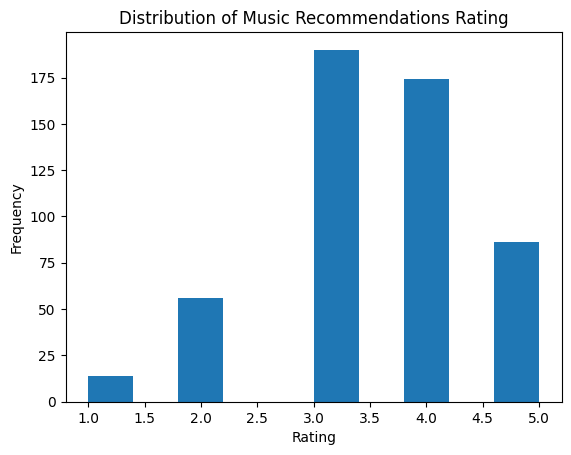

In [463]:
# Examine distribution
plt.hist(df['music_recc_rating'])
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Music Recommendations Rating')
plt.show()

 ### **Data Preprocessing**
music recc rating is discrete rating from 1 to 5 (ordinal). However, for ease of interprability I use discretization. Ratings of 1 and 2 are considered 'low', ratings of 3 are considered 'medium' and ratings of 4 and 5 are considered 'high'.

In [466]:
df['music_recc_rating_bin'] = pd.cut(
    df['music_recc_rating'], 
    bins=[0, 2, 3, 5],
    labels=['low', 'medium', 'high'],
    include_lowest=True
)

In [468]:
for col in df.columns:
    print(f"\nColumn: {col}")
    print(df[col].value_counts(normalize = True, dropna = False))


Column: Age
Age
20-35    0.811538
12-20    0.136538
35-60    0.044231
6-12     0.005769
60+      0.001923
Name: proportion, dtype: float64

Column: Gender
Gender
Female    0.751923
Male      0.219231
Others    0.028846
Name: proportion, dtype: float64

Column: spotify_usage_period
spotify_usage_period
More than 2 years     0.325000
1 year to 2 years     0.271154
6 months to 1 year    0.228846
Less than 6 months    0.175000
Name: proportion, dtype: float64

Column: spotify_listening_device
spotify_listening_device
Smartphone                                                                              0.576923
Computer or laptop                                                                      0.103846
Smartphone, Computer or laptop                                                          0.092308
Smart speakers or voice assistants                                                      0.082692
Computer or laptop, Smart speakers or voice assistants                                  0.02

 ### **Clean missing values**

In [471]:
missing_values_sum = df.isnull().sum()

print(missing_values_sum)

Age                              0
Gender                           0
spotify_usage_period             0
spotify_listening_device         0
spotify_subscription_plan        0
premium_sub_willingness          0
preffered_premium_plan         208
preferred_listening_content      0
fav_music_genre                  0
music_time_slot                  0
music_Influencial_mood           0
music_lis_frequency              0
music_expl_method                0
music_recc_rating                0
pod_lis_frequency                0
fav_pod_genre                  148
preffered_pod_format           140
pod_host_preference            141
preffered_pod_duration         129
pod_variety_satisfaction         0
music_recc_rating_bin            0
dtype: int64


Impute missing variables as NONE

In [474]:
df.loc[df['fav_pod_genre'].isna(), 'fav_pod_genre'] = 'None'
df.loc[df['preffered_pod_format'].isna(), 'preffered_pod_format'] = 'None'
df.loc[df['pod_host_preference'].isna(), 'pod_host_preference'] = 'None'
df.loc[df['preffered_pod_duration'].isna(), 'preffered_pod_duration'] = 'None'
df.loc[df['fav_pod_genre'].isna(), 'fav_pod_genre'] = 'None'
df.loc[df['preffered_premium_plan'].isna(), 'preffered_premium_plan'] = 'None'

Collapse rare categories, set a threshold of 5%. Any category under 5 percent is combined into an 'Other' cateogry.

In [477]:
def collapse_rare_categories(df, col, min_prop=0.05, other_label="Other"):
    freqs = df[col].value_counts(normalize=True)
    keep = freqs[freqs >= min_prop].index
    return df[col].apply(lambda x: x if x in keep else other_label)


df['music_Influencial_mood_simplified'] = collapse_rare_categories(
    df, 'music_Influencial_mood', min_prop=0.05, other_label="Other"
)

print(df['music_Influencial_mood_simplified'].value_counts(normalize=True))


music_Influencial_mood_simplified
Relaxation and stress relief                                                                                     0.375000
Other                                                                                                            0.175000
Uplifting and motivational                                                                                       0.128846
Sadness or melancholy                                                                                            0.105769
Relaxation and stress relief, Uplifting and motivational                                                         0.084615
Relaxation and stress relief, Uplifting and motivational, Sadness or melancholy, Social gatherings or parties    0.067308
Relaxation and stress relief, Sadness or melancholy                                                              0.063462
Name: proportion, dtype: float64


In [479]:
df['music_expl_method_simplified'] = collapse_rare_categories(
    df, 'music_expl_method', min_prop=0.05, other_label="Other"
)

print(df['music_expl_method_simplified'].value_counts(normalize=True))


music_expl_method_simplified
recommendations               0.217308
Playlists                     0.215385
Other                         0.198077
recommendations, Playlists    0.165385
Others                        0.105769
Radio                         0.098077
Name: proportion, dtype: float64


In [481]:
df['spotify_listening_device_simplified'] = collapse_rare_categories(
    df, 'spotify_listening_device', min_prop=0.05, other_label="Other"
)

print(df['spotify_listening_device_simplified'].value_counts(normalize=True))


spotify_listening_device_simplified
Smartphone                            0.576923
Other                                 0.144231
Computer or laptop                    0.103846
Smartphone, Computer or laptop        0.092308
Smart speakers or voice assistants    0.082692
Name: proportion, dtype: float64


In [483]:
df['music_lis_frequency_simplified'] = collapse_rare_categories(
    df, 'music_lis_frequency', min_prop=0.05, other_label="Other"
)

print(df['music_lis_frequency_simplified'].value_counts(normalize=True))

music_lis_frequency_simplified
Other                                             0.338462
While Traveling                                   0.213462
leisure time                                      0.167308
While Traveling, leisure time                     0.125000
While Traveling, Workout session, leisure time    0.092308
Workout session                                   0.063462
Name: proportion, dtype: float64


 ### **Modeling Phase - KMode Clustering**
Utilize kmodes clustering as it is best suited for categorical data.

In [486]:
# Subset dataset into variables of interest
cat_cols = ['Age',
 'Gender',
 'spotify_usage_period',
 'spotify_listening_device_simplified',
 'spotify_subscription_plan',
 'premium_sub_willingness',
 'preffered_premium_plan',
 'preferred_listening_content',
 'fav_music_genre',
 'music_time_slot',
 'music_Influencial_mood_simplified',
 'music_lis_frequency_simplified',
 'music_expl_method_simplified',
 'pod_lis_frequency',
 'fav_pod_genre',
 'preffered_pod_format',
 'pod_host_preference',
 'preffered_pod_duration',
 'pod_variety_satisfaction',
 'music_recc_rating_bin'
]

df_cat = df[cat_cols].copy()

df_cat = df_cat.astype(str)

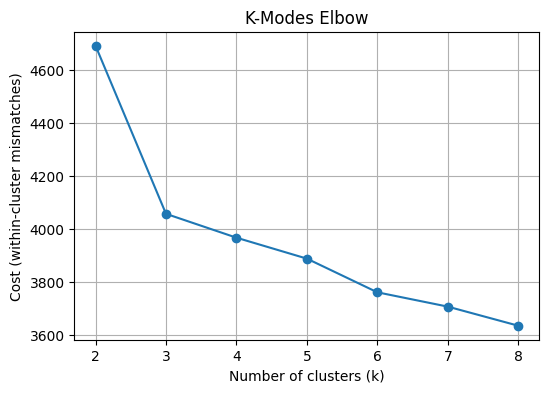

In [488]:
#Create elbow plot to determine best number of clusters
costs = []
K = range(2, 9)  # try 2..8 clusters
for k in K:
    km = KModes(n_clusters=k, init='Cao', n_init=5, verbose=0, random_state=1)
    km.fit_predict(df_cat)
    costs.append(km.cost_)

plt.figure(figsize=(6,4))
plt.plot(list(K), costs, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Cost (within-cluster mismatches)')
plt.title('K-Modes Elbow')
plt.grid(True)
plt.show()


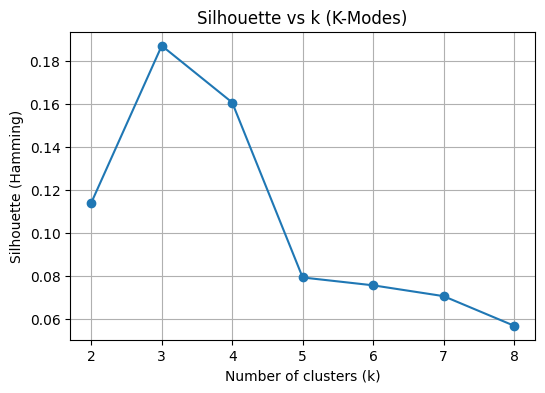

In [489]:
# Examine Silhouette (hamming) metric

# Encode categories as integers per column (label encoding)
df_encoded = pd.DataFrame(index=df_cat.index)
for c in df_cat.columns:
    df_encoded[c] = df_cat[c].astype('category').cat.codes

sil_scores = []
for k in K:
    km = KModes(n_clusters=k, init='Cao', n_init=5, verbose=0, random_state=2)
    labels_k = km.fit_predict(df_cat)
    sil = silhouette_score(df_encoded, labels_k, metric='hamming')
    sil_scores.append(sil)

plt.figure(figsize=(6,4))
plt.plot(list(K), sil_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette (Hamming)')
plt.title('Silhouette vs k (K-Modes)')
plt.grid(True)
plt.show()


In [492]:
#Per both the elbow plot and silhoutte metric, the optimal number of clusters is 3

km_final = KModes(n_clusters=3, init='Cao', n_init=10, verbose=0, random_state=3)
labels = km_final.fit_predict(df_cat)

df_cat['cluster'] = labels
print(df_cat['cluster'].value_counts().sort_index())
print(df_cat['cluster'].value_counts(normalize=True))


cluster
0    264
1    144
2    112
Name: count, dtype: int64
cluster
0    0.507692
1    0.276923
2    0.215385
Name: proportion, dtype: float64


In [494]:
#Examin the centroids of each cluster
centroids = pd.DataFrame(km_final.cluster_centroids_, columns=cat_cols)
centroids.index.name = 'cluster'
print("\nCluster centroids (modes):")
display(centroids)


Cluster centroids (modes):


,Age,Gender,spotify_usage_period,spotify_listening_device_simplified,spotify_subscription_plan,premium_sub_willingness,preffered_premium_plan,preferred_listening_content,fav_music_genre,music_time_slot,music_Influencial_mood_simplified,music_lis_frequency_simplified,music_expl_method_simplified,pod_lis_frequency,fav_pod_genre,preffered_pod_format,pod_host_preference,preffered_pod_duration,pod_variety_satisfaction,music_recc_rating_bin
cluster,,,,,,,,,,,,,,,,,,,,
0,20-35,Female,More than 2 years,Smartphone,Free (ad-supported),No,None,Music,Melody,Night,Relaxation and stress relief,Other,Playlists,Rarely,Comedy,Story telling,Both,Shorter,Ok,high
1,20-35,Female,More than 2 years,Smartphone,Free (ad-supported),No,None,Music,Melody,Night,Relaxation and stress relief,Other,recommendations,Never,None,None,None,None,Ok,high
2,20-35,Female,6 months to 1 year,Computer or laptop,Free (ad-supported),Yes,Duo plan- Rs 149/month,Podcast,classical,Afternoon,Sadness or melancholy,Other,Radio,Once a week,Health and Fitness,Story telling,unknown Podcasters,Longer,Ok,medium


In [496]:
#For each variable examine the cluster proportion, the overall proportion, the differance and the lift
def overrepresented_by_cluster(df_cat, cluster_col='cluster', topn=5, min_overall_prop=0.03):
    cat_cols = [c for c in df_cat.columns if c != cluster_col]
    
    # overall proportions for each column (dict of Series)
    overall_props = {c: df_cat[c].value_counts(normalize=True) for c in cat_cols}

    results = {}  # {column: DataFrame of top rows across clusters}
    for c in cat_cols:
        # cluster-wise proportions for each category
        cl_props = (
            df_cat.groupby(cluster_col)[c]
                  .value_counts(normalize=True)
                  .rename('prop_cluster')
                  .reset_index()
        )
        # attach overall proportion for the same category
        cl_props['prop_overall'] = cl_props[c].map(overall_props[c]).fillna(0)
        # skip very rare categories overall
        cl_props = cl_props[cl_props['prop_overall'] >= min_overall_prop].copy()

        # diffs & lift (how much above overall)
        cl_props['diff'] = cl_props['prop_cluster'] - cl_props['prop_overall']
        # add a tiny epsilon to avoid divide-by-zero
        cl_props['lift'] = cl_props['prop_cluster'] / (cl_props['prop_overall'] + 1e-12)

        # pick topn per cluster by diff
        tops = (cl_props.sort_values(['cluster', 'diff'], ascending=[True, False])
                        .groupby(cluster_col)
                        .head(topn))
        results[c] = tops[[cluster_col, c, 'prop_cluster', 'prop_overall', 'diff', 'lift']]

    return results


tops = overrepresented_by_cluster(df_cat, cluster_col='cluster', topn=5, min_overall_prop=0.03)

# formatting
for col, df_top in tops.items():
    print(f"\n=== {col} ===")
    for cl, sub in df_top.groupby('cluster'):
        print(f"\nCluster {cl} — Top over-represented categories")
        print(sub.sort_values('diff', ascending=False)
                 .rename(columns={'prop_cluster':'cluster_prop', 'prop_overall':'overall_prop'})
                 .to_string(index=False))



=== Age ===

Cluster 0 — Top over-represented categories
 cluster   Age  cluster_prop  overall_prop      diff     lift
       0 20-35      0.867424      0.811538  0.055886 1.068864
       0 35-60      0.045455      0.044231  0.001224 1.027668
       0 12-20      0.079545      0.136538 -0.056993 0.582586

Cluster 1 — Top over-represented categories
 cluster   Age  cluster_prop  overall_prop      diff     lift
       1 20-35      0.916667      0.811538  0.105128 1.129542
       1 35-60      0.013889      0.044231 -0.030342 0.314010
       1 12-20      0.069444      0.136538 -0.067094 0.508607

Cluster 2 — Top over-represented categories
 cluster   Age  cluster_prop  overall_prop      diff     lift
       2 12-20      0.357143      0.136538  0.220604 2.615694
       2 35-60      0.080357      0.044231  0.036126 1.816770
       2 20-35      0.544643      0.811538 -0.266896 0.671124

=== Gender ===

Cluster 0 — Top over-represented categories
 cluster Gender  cluster_prop  overall_prop    

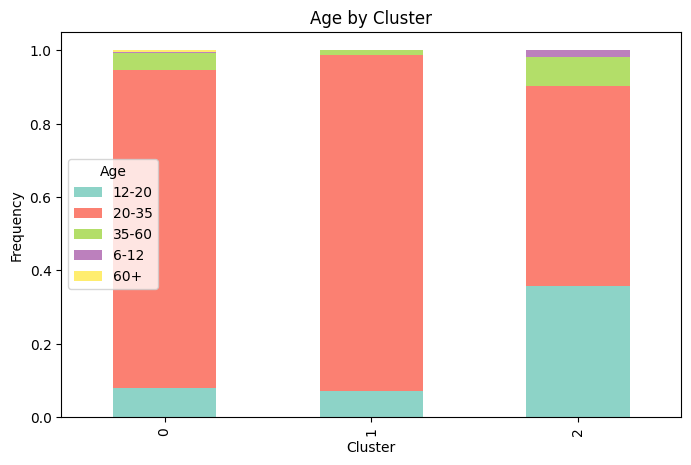

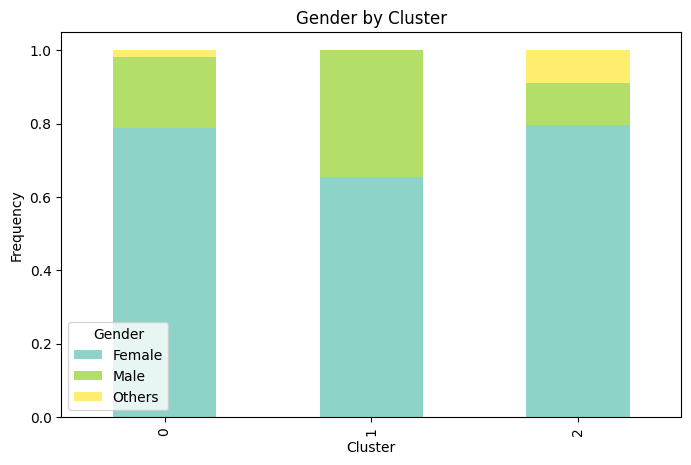

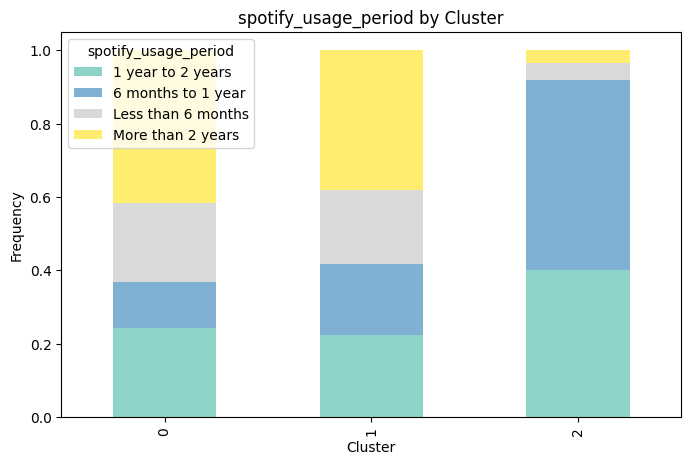

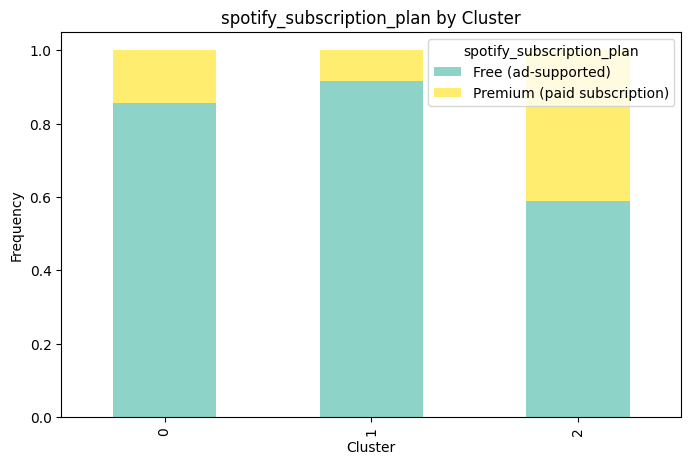

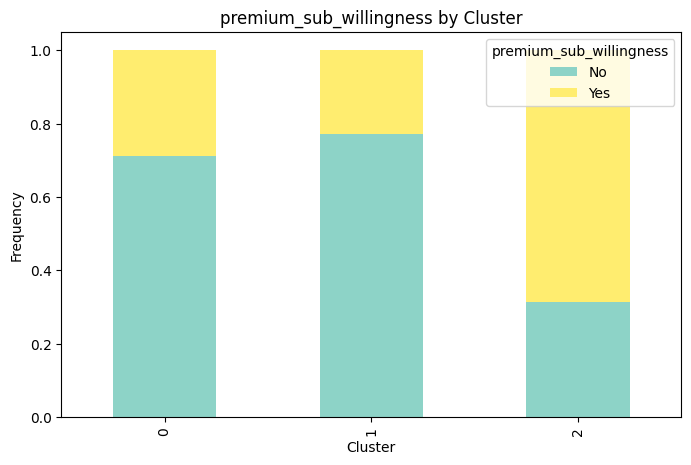

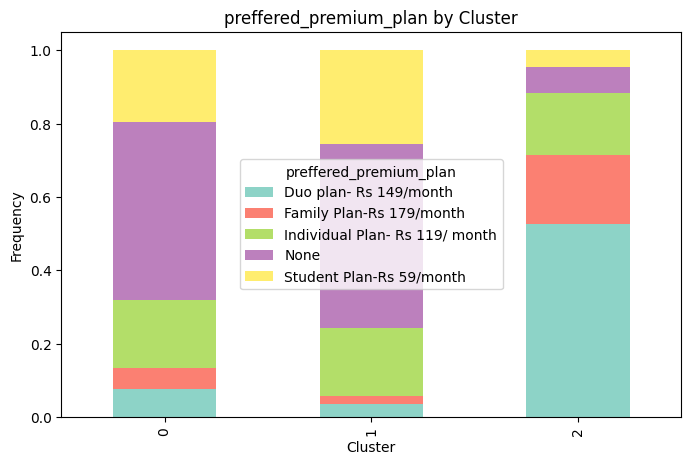

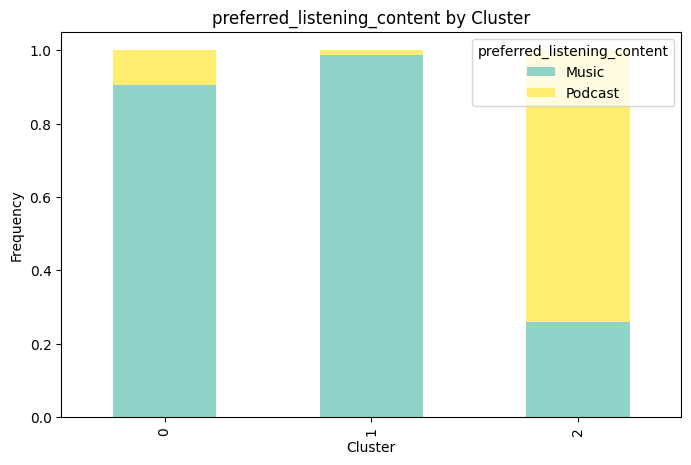

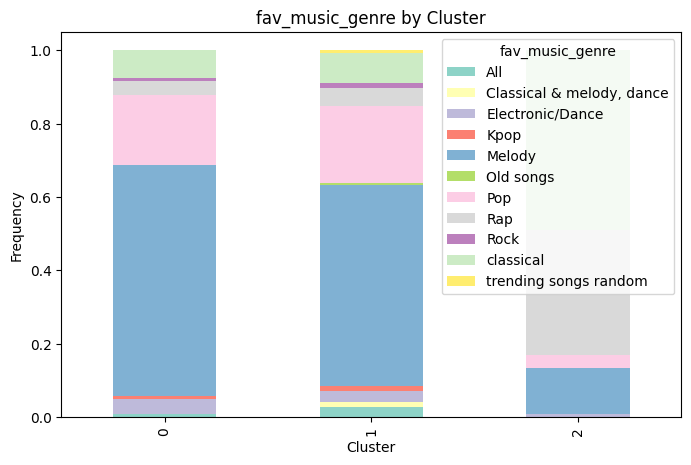

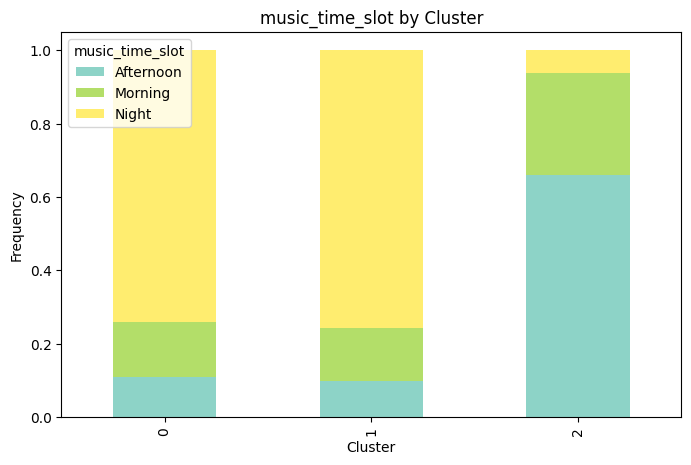

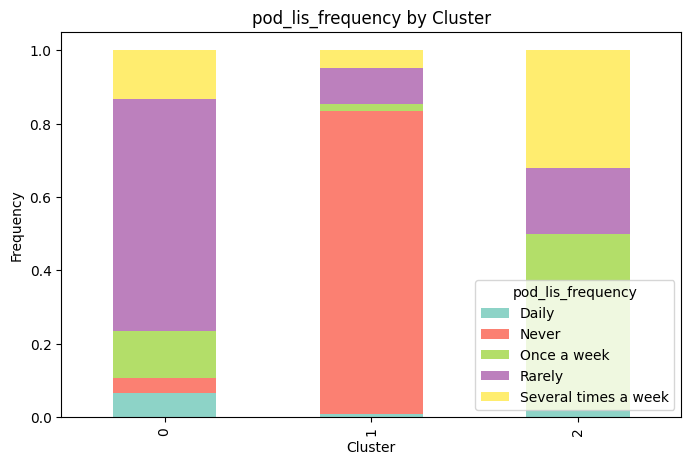

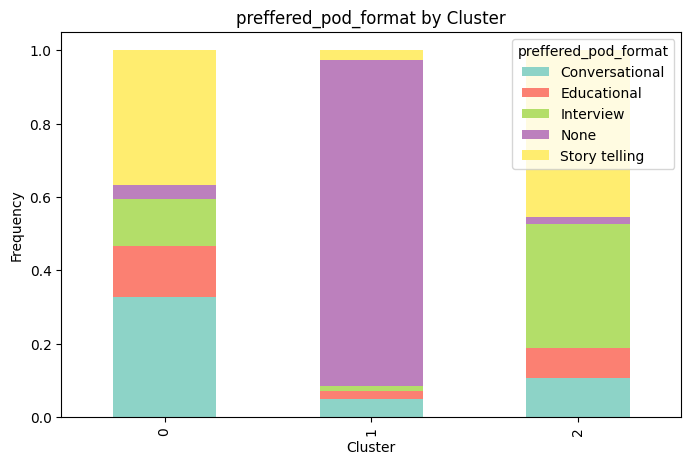

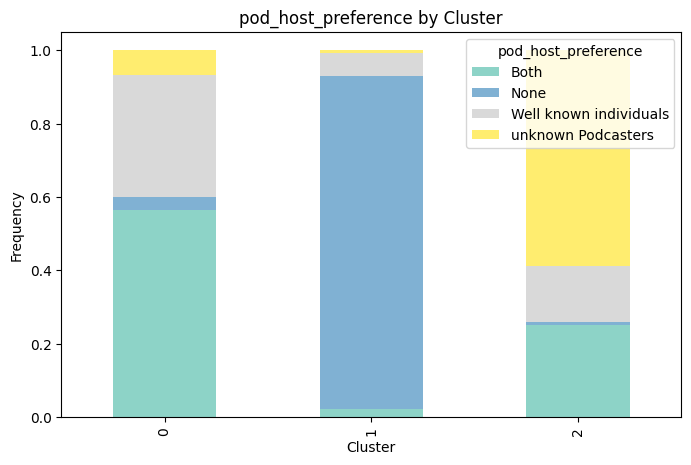

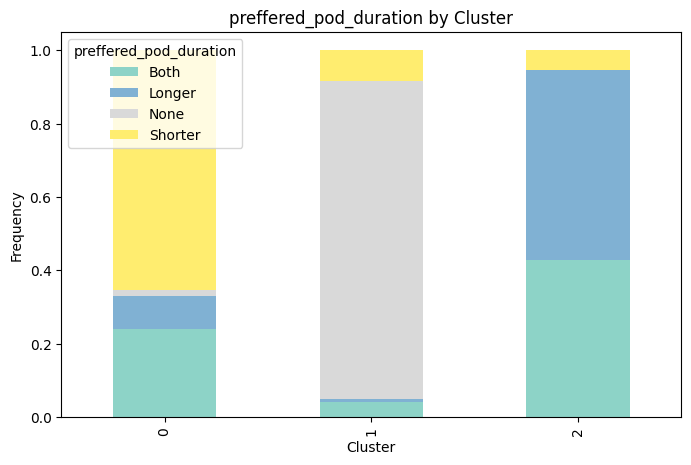

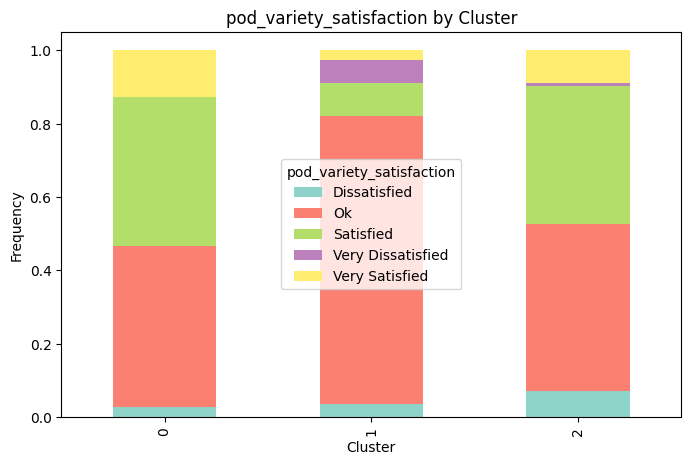

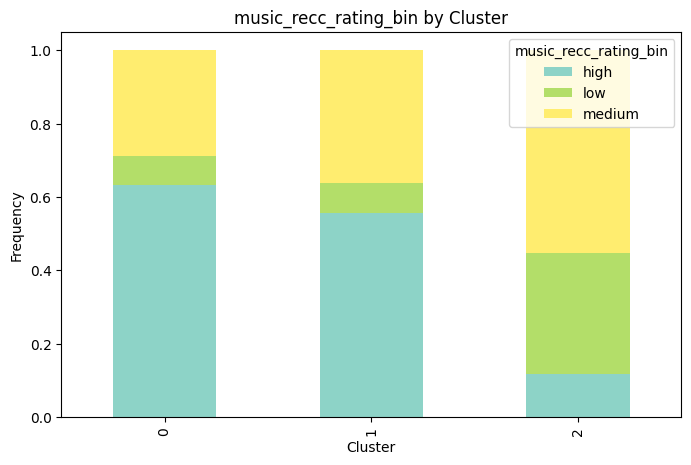

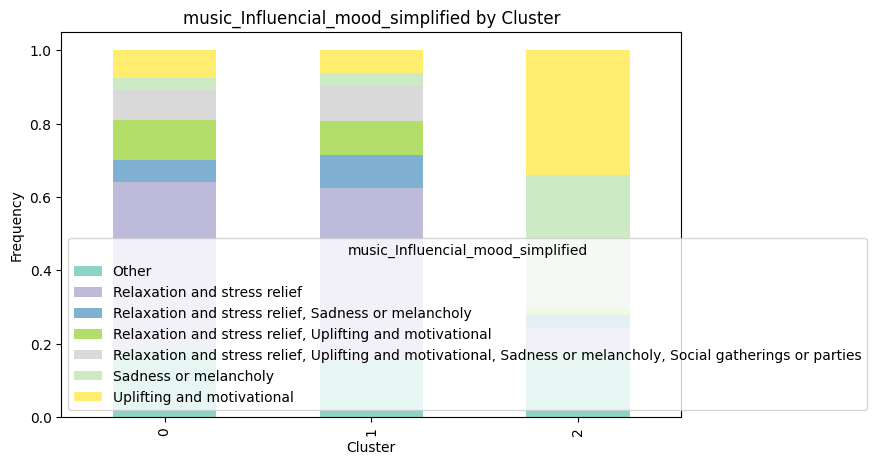

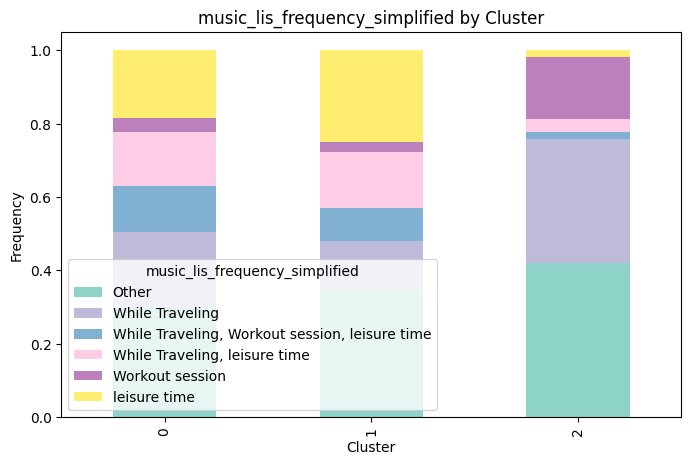

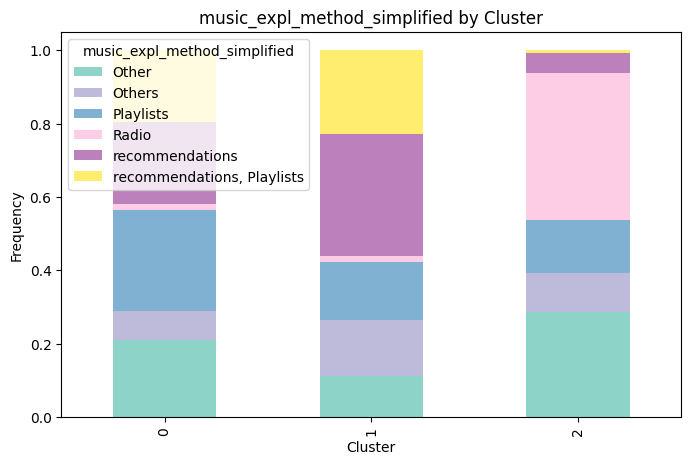

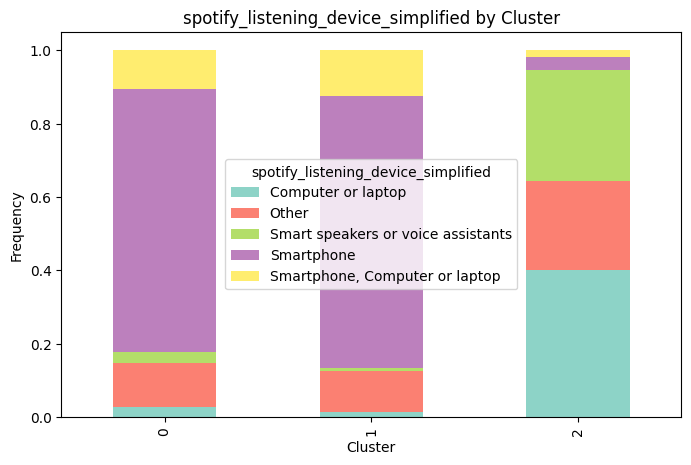

In [498]:
# GRAPHS Subset dataset 
df_graph = df_cat[['Age',
 'Gender',
 'spotify_usage_period',
 'spotify_subscription_plan',
 'premium_sub_willingness',
 'preffered_premium_plan',
 'preferred_listening_content',
 'fav_music_genre',
 'music_time_slot',
 'pod_lis_frequency',
 'preffered_pod_format',
 'pod_host_preference',
 'preffered_pod_duration',
 'pod_variety_satisfaction',
 'music_recc_rating_bin',
 'music_Influencial_mood_simplified',
 'music_lis_frequency_simplified',
 'music_expl_method_simplified',
'spotify_listening_device_simplified']]


for var in df_graph.columns: 
    pd.crosstab(df_cat['cluster'], df_cat[var], normalize='index').plot(
    kind='bar', stacked=True, figsize=(8,5), colormap="Set3")
    
    plt.title(f'{var} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Frequency')

plt.show()


### **Association Analysis**

encode categorical variables as binary dummy variables

In [501]:
multi_select_cols = ['music_expl_method_simplified', 'spotify_listening_device_simplified', 'music_Influencial_mood_simplified', 'music_lis_frequency_simplified']

# Loop through each column
for col in multi_select_cols:
    s = (df[col].fillna('')
                .str.lower()
                .str.replace(r'\s*,\s*', ',', regex=True)
                .str.strip())

    dummies = s.str.get_dummies(sep=',')
    
    dummies = dummies.add_prefix(col + '_')
    
    # Join back to main df
    df = pd.concat([df, dummies], axis=1)

In [504]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

encoded = ohe.fit_transform(df[['Age','Gender', 'preffered_premium_plan','preferred_listening_content','fav_music_genre',	'music_time_slot',
'fav_pod_genre', 'preffered_pod_format', 'pod_host_preference', 'preffered_pod_duration', 'spotify_subscription_plan', 'premium_sub_willingness']])
encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(['Age','Gender', 'preffered_premium_plan','preferred_listening_content','fav_music_genre',	'music_time_slot',
'fav_pod_genre', 'preffered_pod_format', 'pod_host_preference', 'preffered_pod_duration', 'spotify_subscription_plan', 'premium_sub_willingness']))


df_encode = pd.concat([df, encoded_df], axis=1)

In [506]:
df_assoc = df_encode[['music_expl_method_friends',
 'music_expl_method_others',
 'music_expl_method_playlists',
 'music_expl_method_radio',
 'music_expl_method_recommendations',
 'music_expl_method_search',
 'music_expl_method_social media',
 'music_Influencial_mood_relaxation and stress relief',
 'music_Influencial_mood_sadness or melancholy',
 'music_Influencial_mood_social gatherings or parties',
 'music_Influencial_mood_uplifting and motivational',
 'music_lis_frequency_before bed',
 'music_lis_frequency_leisure time',
 'music_lis_frequency_night time',
 'music_lis_frequency_office hours',
 'music_lis_frequency_random',
 'music_lis_frequency_social gatherings',
 'music_lis_frequency_study hours',
 'music_lis_frequency_when cooking',
 'music_lis_frequency_while traveling',
 'music_lis_frequency_workout session',
 'fav_music_genre_All',
 'fav_music_genre_Classical & melody, dance',
 'fav_music_genre_Electronic/Dance',
 'fav_music_genre_Kpop',
 'fav_music_genre_Melody',
 'fav_music_genre_Old songs',
 'fav_music_genre_Pop',
 'fav_music_genre_Rap',
 'fav_music_genre_Rock',
 'fav_music_genre_classical',
 'fav_music_genre_trending songs random',
 'music_time_slot_Afternoon',
 'music_time_slot_Morning',
 'music_time_slot_Night'
]]

KeyError: "['music_expl_method_friends', 'music_expl_method_others', 'music_expl_method_playlists', 'music_expl_method_radio', 'music_expl_method_recommendations', 'music_expl_method_search', 'music_expl_method_social media', 'music_Influencial_mood_relaxation and stress relief', 'music_Influencial_mood_sadness or melancholy', 'music_Influencial_mood_social gatherings or parties', 'music_Influencial_mood_uplifting and motivational', 'music_lis_frequency_before bed', 'music_lis_frequency_leisure time', 'music_lis_frequency_night time', 'music_lis_frequency_office hours', 'music_lis_frequency_random', 'music_lis_frequency_social gatherings', 'music_lis_frequency_study hours', 'music_lis_frequency_when cooking', 'music_lis_frequency_while traveling', 'music_lis_frequency_workout session'] not in index"

In [507]:
pd.set_option('display.max_colwidth', None)  
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', 200)         

# make sure all variables are dummy variables
df_assoc_bool = df_assoc.astype(bool)


frequent_itemsets = apriori(df_assoc_bool, min_support=0.05, max_len=2, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Sort by strongest lift
rules = rules.sort_values("lift", ascending=False)

print(rules[['antecedents','consequents','support','confidence','lift']].head(10))

                                 antecedents                               consequents   support  confidence      lift
13        (fav_pod_genre_Health and Fitness)  (pod_host_preference_unknown Podcasters)  0.076923    0.512821  3.137255
12  (pod_host_preference_unknown Podcasters)        (fav_pod_genre_Health and Fitness)  0.076923    0.470588  3.137255
17           (preffered_pod_duration_Longer)        (fav_pod_genre_Health and Fitness)  0.063462    0.397590  2.650602
16        (fav_pod_genre_Health and Fitness)           (preffered_pod_duration_Longer)  0.063462    0.423077  2.650602
63           (preffered_pod_duration_Longer)  (pod_host_preference_unknown Podcasters)  0.067308    0.421687  2.579731
62  (pod_host_preference_unknown Podcasters)           (preffered_pod_duration_Longer)  0.067308    0.411765  2.579731
40          (preffered_pod_format_Interview)           (preffered_pod_duration_Longer)  0.050000    0.351351  2.201237
41           (preffered_pod_duration_Longer)    

In [510]:
df_assoc = df_encode[['fav_pod_genre_Business',
 'fav_pod_genre_Comedy',
 'fav_pod_genre_Dance and Relevant cases ',
 'fav_pod_genre_Educational ',
 'fav_pod_genre_Everything',
 'fav_pod_genre_Finance related and current affairs',
 'fav_pod_genre_Food and cooking',
 'fav_pod_genre_General knowledge ',
 'fav_pod_genre_Health and Fitness',
 'fav_pod_genre_Informative stuff',
 'fav_pod_genre_Lifestyle and Health',
 'fav_pod_genre_Murder Mystery ',
 'fav_pod_genre_Novels',
 'fav_pod_genre_Political, informative, topics that interests me',
 'fav_pod_genre_Self help',
 'fav_pod_genre_Spiritual and devotional',
 'fav_pod_genre_Sports',
 'fav_pod_genre_Stories ',
 'fav_pod_genre_Technology',
 'preffered_pod_format_Conversational',
 'preffered_pod_format_Educational',
 'preffered_pod_format_Interview',
 'preffered_pod_format_Story telling',
 'pod_host_preference_Both',
 'pod_host_preference_Well known individuals',
 'pod_host_preference_unknown Podcasters',
 'preffered_pod_duration_Both',
 'preffered_pod_duration_Longer',
 'preffered_pod_duration_Shorter']]

df_assoc_bool = df_assoc.astype(bool)

frequent_itemsets = apriori(df_assoc_bool, min_support=0.05, max_len=2, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Sort by strongest lift
rules = rules.sort_values("lift", ascending=False)

print(rules[['antecedents','consequents','support','confidence','lift']].head(10))

                                 antecedents                               consequents   support  confidence      lift
13        (fav_pod_genre_Health and Fitness)  (pod_host_preference_unknown Podcasters)  0.076923    0.512821  3.137255
12  (pod_host_preference_unknown Podcasters)        (fav_pod_genre_Health and Fitness)  0.076923    0.470588  3.137255
17           (preffered_pod_duration_Longer)        (fav_pod_genre_Health and Fitness)  0.063462    0.397590  2.650602
16        (fav_pod_genre_Health and Fitness)           (preffered_pod_duration_Longer)  0.063462    0.423077  2.650602
63           (preffered_pod_duration_Longer)  (pod_host_preference_unknown Podcasters)  0.067308    0.421687  2.579731
62  (pod_host_preference_unknown Podcasters)           (preffered_pod_duration_Longer)  0.067308    0.411765  2.579731
40          (preffered_pod_format_Interview)           (preffered_pod_duration_Longer)  0.050000    0.351351  2.201237
41           (preffered_pod_duration_Longer)    

## **Discussion**
The KModes clustering analysis was used to reveal three distinct user segments based of Spotfy user behavior survey data. Additional assocation analysis revealed further insightes in the user base. Refering back to the original analysis questions:

#### What meaningful user segments can be uncovered through clustering analysis?

The KModes clustering identified three distinct user segments that differ in demographics, listening behaviors, and subscription preferences. For example:

- Cluster 0 - Consists mainly of free users who listen primarily on smartphones, enjoy music (especially melody and pop), and are light podcast listeners.
- Cluster 1 - Contains mostly free users as well, but they are more likely to discover music through playlists and recommendations and listen predominantly at night.
- Cluster 2 - Is distinct in showing a higher proportion of premium users, greater willingness to subscribe, stronger engagement with podcasts, and preferences for classical and rap music.

These distinctions suggest that clustering successfully segmented Spotify users into cohesive and interpretable groups that align with differences in product usage and preferences.

#### How can these customer segments inform business decisions?

The segments can inform Spotify’s marketing, product, and retention strategies:

- Cluster 0 - Marketing can focus on converting these heavy music listeners into premium subscribers by highlighting ad-free music and mobile convenience.
- Cluster 1 - Engagement strategies could emphasize playlist curation, personalized recommendations, and social-sharing features to deepen their reliance on Spotify for discovery.
- Cluster 2 - Spotify can tailor retention and upselling strategies to emphasize podcast variety, exclusive content, and premium features since this group already shows high subscription willingness.

By tailoring campaigns and product design to each cluster, Spotify could improve conversion, satisfaction, and retention while optimizing how resources are allocated across user types.

#### What additional relationships between attributes can be uncovered through association analysis?

 The association rule mining revealed non-obvious relationships between attributes that complement the clustering analysis. For example:

- Rap fans are twice as likely to listen in the afternoon.
- Classical music fans are twice as likely to use the Spotify radio feature.
- Users who use Spotify for studying are twice as likely to use the Spotify radio feature.
- Comedy podcast listeners are more than 2.5x as likely to prefer storytelling in shorter formats.
- Health & fitness podcast listeners are over 3x as likely to prefer unknown podcasters and 2.6x as likely to prefer longer podcasts.

These rules provide cross-feature insights that help explain how specific user tastes translate into behaviors. These findings can use these findings to improve personalization algorithms, ad targeting, and recommendation systems. For example, study specific radio stations can be created and recommended during the afternoon for higher engagement. Podcasts insights can be provided to Spotify podcasts partners to help hosts better understand user preferences.
